# Week 4 Advanced Arima modeling
## Time Series Analysis
### Earnest Salgado
### ID 12285784

In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sktime.forecasting.all import ForecastingHorizon
from sktime.forecasting.all import ExponentialSmoothing
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

/Users/earnestsalgado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
/Users/earnestsalgado/opt/anaconda3/lib/python3.9/site-packages/sktime/utils/validation/_dependencies.py:64: UserWarning: No module named 'prophet'. 'prophet' is a soft dependency and not included in the sktime installation. Please run: `pip install prophet` to install the prophet package. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(msg)


## 1. 10 pts - Exploratory Data Analysis

### 1.A 10 pts Complete a quantitative and qualitative data exploration. Include a verbal summary of your EDA.
- Reading in the data we can observe Carbon Dioxide levels over time is our time series data topic this week. It is the only variable (besides time, of course)!
- Visually inspecting our data in a plot, we can observe a positive upward trend over time. 
- There are 735 data points in our series, with a mean carbon dioxide level of 354.210673 and standard deviation of 27.922811. The minimum value in the data set is 313.2; the maximum value is 414.83. The carbon dioxide levels are recorded between a time period of March 1958 to May 2019.
- We conduct a check for null or missing values and find there are no missing values.

In [2]:
df = pd.read_csv('hw4_data.csv', parse_dates = ['ds'])

In [3]:
df

,ds,co2
0,1958-03-15,315.700
1,1958-04-15,317.450
2,1958-05-15,317.510
3,1958-06-15,316.685
4,1958-07-15,315.860
...,...,...
730,2019-01-15,410.920
731,2019-02-15,411.660
732,2019-03-15,412.000
733,2019-04-15,413.510


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
co2,735.0,354.210673,27.922811,313.2,328.785,351.34,376.515,414.83


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      735 non-null    datetime64[ns]
 1   co2     735 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.6 KB


In [6]:
df.isnull().sum()

ds     0
co2    0
dtype: int64

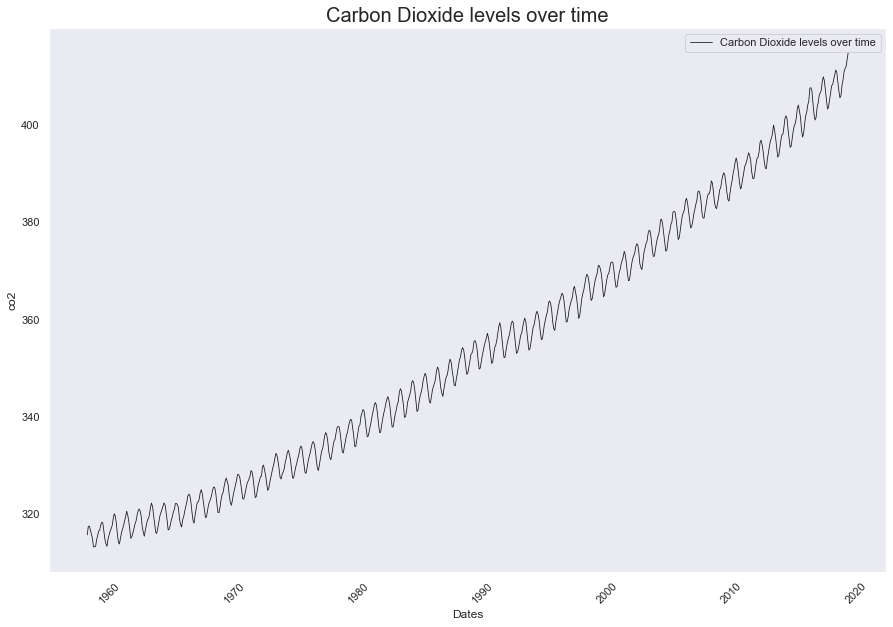

In [7]:
x = df['ds']

y = df['co2']

plt.figure(figsize=(15,10))  
plt.plot(x,y, color = 'k',label = "Carbon Dioxide levels over time", ls = '-', lw = 0.8)
#plt.plot(x, z, color = 'g',label = "SPY Price over time", ls = '-', lw = 0.8)

plt.xticks(rotation = 45)
plt.xlabel('Dates')
plt.ylabel('co2')
plt.title('Carbon Dioxide levels over time', fontsize = 20)
plt.grid()
plt.legend()
plt.show()

In [8]:
# correlation table with all the numeric features
df.corr()

,co2
co2,1.0


<AxesSubplot:>

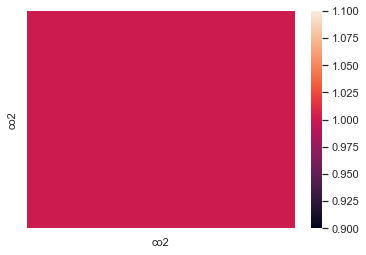

In [9]:
# heatmap based on the correlation table from above
sns.heatmap(df.corr())

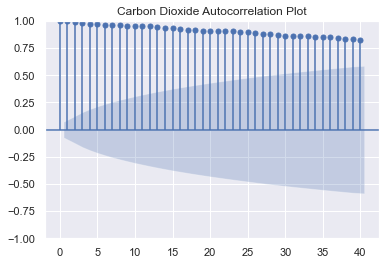

In [10]:
p = plot_acf(df['co2'], lags=40, title='Carbon Dioxide Autocorrelation Plot')

## 2. 30 pts – Seasonal ARIMA – need to use statsmodels in order to examine residuals
### 2.A - 6 pts Determine the seasonal differencing order, use y_train. Include the following: plot of differenced data, ADF results, kpss results
- When initially loading the original time series data for co2, we can immediately notice it has an upward trend and changing mean but uniform variance. Thus by definition it is not showing stationarity
- When we do a first seasonal differencing, the upward trend begins to dampen however it is still visible. 
- After a second seasonal differencing, the plot is observed to remain around zero for most of the time, a characteristic of stationarity. We can then confirm stationarity in the dataset by employing KPSS and ADFuller tests. 
- We determine the order by differencing the data and applying ADF and KPSS tests. After the second pass, ADF test shows the p-values are less than 0.05 so the Null hypothesis can be rejected. If it is not null then we know the TS does npt possess a unit root and hence is stationary. Rejecting the Null hypothesis would mean TS is not stationary. KPSS tests also show the p-values are greater than 0.05. This means that the Null hypothesis of stationarity cannot be rejected. If it is null then we know the TS has stationary characteristics. Alternate hypothesis would mean TS is not stationary.
- The ACF plot reveal autocorrelation is present. Seasonality is observed in the PACF plot.
- Stationarity is achieved after differencing the data twice.

In [11]:
from statsmodels.tsa.statespace import sarimax
from statsmodels.tools.eval_measures import aicc
from sktime.transformations.series import boxcox
from sktime.forecasting.arima import ARIMA

<AxesSubplot:xlabel='ds'>

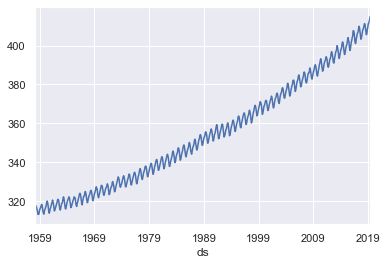

In [12]:
# selecting variable of intest & build uniform univariate time series
ts = df.groupby(pd.PeriodIndex(df['ds'], freq="M"))['co2'].mean()
ts.plot()

In [13]:
ts

ds
1958-03    315.700
1958-04    317.450
1958-05    317.510
1958-06    316.685
1958-07    315.860
            ...   
2019-01    410.920
2019-02    411.660
2019-03    412.000
2019-04    413.510
2019-05    414.830
Freq: M, Name: co2, Length: 735, dtype: float64

In [14]:
# set date as index
#df.set_index('ds', inplace = True)

In [15]:
# take a log transformation
bctransformer = boxcox.BoxCoxTransformer()
ts_transf = bctransformer.fit_transform(ts)

### Split into Train/test ( )

In [16]:
from sktime.forecasting.all import temporal_train_test_split
y_train, y_test = temporal_train_test_split(ts)

In [17]:
y_train.index.min(), y_train.index.max()

(Period('1958-03', 'M'), Period('2004-01', 'M'))

In [18]:
y_test.index.min(), y_test.index.max()

(Period('2004-02', 'M'), Period('2019-05', 'M'))

In [19]:
print(y_train.shape)
print(y_test.shape)

(551,)
(184,)


### Examine Stationarity

In [20]:
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from copy import deepcopy

def adf_test(timeseries):
    print ('Dickey-Fuller Test Result:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#define KPSS
def kpss_test(timeseries, trend='c'):
    print ('KPSS Test Result:')
    kpsstest = kpss(timeseries, regression=trend)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [21]:
adf_test(y_train)

Dickey-Fuller Test Result:
Test Statistic                   2.899722
p-value                          1.000000
#Lags Used                      13.000000
Number of Observations Used    537.000000
Critical Value (1%)             -3.442586
Critical Value (5%)             -2.866937
Critical Value (10%)            -2.569645
dtype: float64


In [22]:
adf_co2 = adfuller(y_train)
ad_fuller_pval = adf_co2[1]

if ad_fuller_pval <= 0.05:
    print('stationarity from ad_fuller test: TRUE')
else:
    print('stationarity from ad_fuller test: FALSE')

stationarity from ad_fuller test: FALSE


In [23]:
kpss_test(y_train)

KPSS Test Result:
Test Statistic            3.525562
p-value                   0.010000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [24]:
kpss_co2 = kpss(y_train)
kpss_pval = kpss_co2[1]

if kpss_pval >= 0.05:
    print('stationarity from kpss_fuller test: TRUE')
else:
    print('stationarity from kpss_fuller test: FALSE')

stationarity from kpss_fuller test: FALSE


### No stationarity in original co2 y_train... Difference the data and examine again

In [25]:
y_train_seasdiff = y_train.diff(12).dropna()

In [26]:
y_train_seasdiff

ds
1959-03    0.950
1959-04    0.270
1959-05    0.780
1959-06    1.465
1959-07    0.680
           ...  
2003-09    2.280
2003-10    2.750
2003-11    2.270
2003-12    1.910
2004-01    2.110
Freq: M, Name: co2, Length: 539, dtype: float64

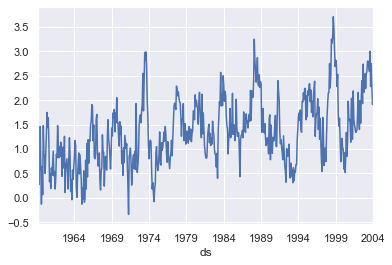

In [27]:
y_train_seasdiff.plot()
plt.show()

In [28]:
adf_test(y_train_seasdiff)

Dickey-Fuller Test Result:
Test Statistic                  -3.992752
p-value                          0.001449
#Lags Used                      13.000000
Number of Observations Used    525.000000
Critical Value (1%)             -3.442867
Critical Value (5%)             -2.867061
Critical Value (10%)            -2.569710
dtype: float64


In [29]:
adf_co2 = adfuller(y_train_seasdiff)
ad_fuller_pval = adf_co2[1]

if ad_fuller_pval <= 0.05:
    print('stationarity from ad_fuller test: TRUE')
else:
    print('stationarity from ad_fuller test: FALSE')

stationarity from ad_fuller test: TRUE


In [30]:
kpss_test(y_train_seasdiff)

KPSS Test Result:
Test Statistic            1.428892
p-value                   0.010000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [31]:
kpss_co2 = kpss(y_train_seasdiff)
kpss_pval = kpss_co2[1]

if kpss_pval >= 0.05:
    print('stationarity from kpss_fuller test: TRUE')
else:
    print('stationarity from kpss_fuller test: FALSE')

stationarity from kpss_fuller test: FALSE


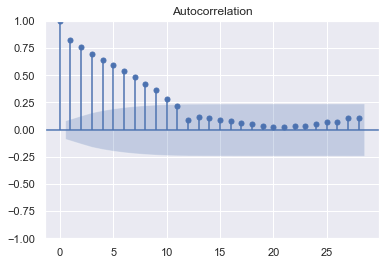

In [32]:
plot_acf(y_train_seasdiff)
plt.show()

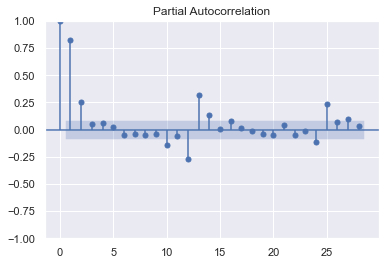

In [33]:
plot_pacf(y_train_seasdiff)
plt.show()

### ADF and KPSS tests come up inconclusive still! No stationarity yet so we difference the data one more time

In [34]:
y_train_seasdiff2 = y_train_seasdiff.diff(12).dropna()

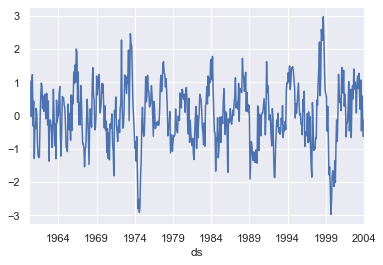

In [35]:
y_train_seasdiff2.plot()
plt.show()

In [36]:
adf_test(y_train_seasdiff2)

Dickey-Fuller Test Result:
Test Statistic                -6.495098e+00
p-value                        1.199777e-08
#Lags Used                     1.900000e+01
Number of Observations Used    5.070000e+02
Critical Value (1%)           -3.443314e+00
Critical Value (5%)           -2.867258e+00
Critical Value (10%)          -2.569815e+00
dtype: float64


In [37]:
adf_co2 = adfuller(y_train_seasdiff2)
ad_fuller_pval = adf_co2[1]

if ad_fuller_pval <= 0.05:
    print('stationarity from ad_fuller test: TRUE')
else:
    print('stationarity from ad_fuller test: FALSE')

stationarity from ad_fuller test: TRUE


In [38]:
kpss_test(y_train_seasdiff2)

KPSS Test Result:
Test Statistic            0.019581
p-value                   0.100000
Lags Used                14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [39]:
kpss_co2 = kpss(y_train_seasdiff2)
kpss_pval = kpss_co2[1]

if kpss_pval >= 0.05:
    print('stationarity from kpss_fuller test: TRUE')
else:
    print('stationarity from kpss_fuller test: FALSE')

stationarity from kpss_fuller test: TRUE


### 2.B - 6 pts Determine the non-seasonal differencing order, use the seasonally differenced training time series. Include the following: plot of differenced data, ADF results, kpss results, ACF and PACF
- When we do a first non-seasonal differencing, the mean and variance oscillate around zero which is a characteristic of stationarity. We verify our visual inspection findings by conducting ADF and KPSS tests.

### Examine ACF and PACF plots

In [40]:
#y_train_nonseasdiff = np.diff(y_train_seasdiff)
y_train_nonseasdiff = y_train_seasdiff.diff(12).dropna()

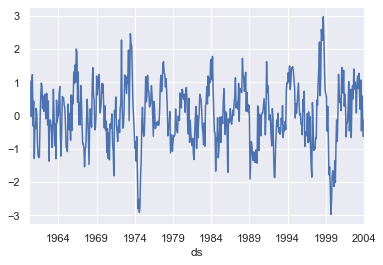

In [41]:
y_train_nonseasdiff.plot()
plt.show()

In [42]:
adf_test(y_train_nonseasdiff)

Dickey-Fuller Test Result:
Test Statistic                -6.495098e+00
p-value                        1.199777e-08
#Lags Used                     1.900000e+01
Number of Observations Used    5.070000e+02
Critical Value (1%)           -3.443314e+00
Critical Value (5%)           -2.867258e+00
Critical Value (10%)          -2.569815e+00
dtype: float64


In [43]:
adf_gdp = adfuller(y_train_nonseasdiff)
ad_fuller_pval = adf_gdp[1]

if ad_fuller_pval <= 0.05:
    print('stationarity from ad_fuller test: TRUE')
else:
    print('stationarity from ad_fuller test: FALSE')

stationarity from ad_fuller test: TRUE


In [44]:
kpss_test(y_train_nonseasdiff)

KPSS Test Result:
Test Statistic            0.019581
p-value                   0.100000
Lags Used                14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [45]:
kpss_gdp = kpss(y_train_nonseasdiff)
kpss_pval = kpss_gdp[1]

if kpss_pval >= 0.05:
    print('stationarity from kpss_fuller test: TRUE')
else:
    print('stationarity from kpss_fuller test: FALSE')

stationarity from kpss_fuller test: TRUE


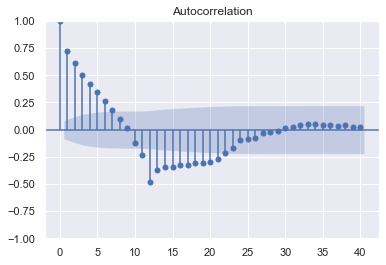

In [46]:
plot_acf(y_train_nonseasdiff, lags = 40)
plt.show()

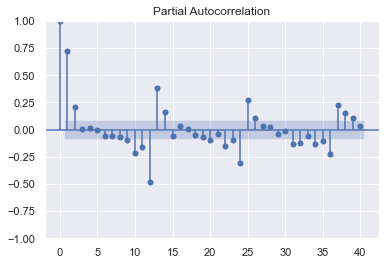

In [47]:
plot_pacf(y_train_nonseasdiff, lags = 40)
plt.show()

### 2.C - 6 pts Fit and predict a SARIMA model using your best estimate of the SARIMA(p,d,q)(P,D,Q)m order. Return the model summary

In [48]:
sarima_model = sm.tsa.statespace.SARIMAX(endog=y_train,order=(3,1,1), seasonal_order=(0, 1, 0, 12))
sarima_fit = sarima_model.fit()
print(sarima_fit.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.38861D-01    |proj g|=  2.30667D-02

At iterate    5    f=  4.38703D-01    |proj g|=  3.96720D-03

At iterate   10    f=  4.38225D-01    |proj g|=  3.23272D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     19      1     0     0   2.936D-05   4.382D-01
  F =  0.43822466316382330     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                      SARIMAX Results                 

 This problem is unconstrained.


### 2.D - 6 pts Examine the residuals. Include the following: plot, histogram, ACF, Ljung Box results

In [49]:
# Return AICc
print("AICc for order " + str(sarima_model.order) + str(sarima_model.seasonal_order) +": " +str(sarima_fit.aicc))

AICc for order (3, 1, 1)(0, 1, 0, 12): 493.0363607614205


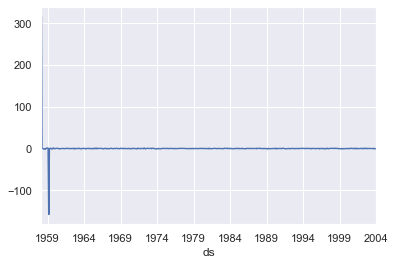

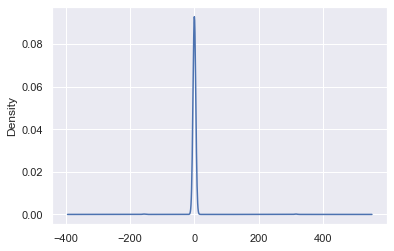

count    551.000000
mean       0.292052
std       15.049708
min     -157.680013
25%       -0.264896
50%        0.004817
75%        0.246577
max      315.700000
dtype: float64


In [50]:
# residual checks
# line plot of residuals
residuals = sarima_fit.resid
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [51]:
residuals

ds
1958-03    315.700000
1958-04      1.750008
1958-05      0.060000
1958-06     -0.824998
1958-07     -0.825001
              ...    
2003-09     -0.592367
2003-10      0.244467
2003-11     -0.365515
2003-12     -0.542158
2004-01      0.029129
Freq: M, Length: 551, dtype: float64

In [52]:
resid = residuals[24:]
resid

ds
1960-03    0.284510
1960-04    0.477745
1960-05    0.592484
1960-06   -0.060338
1960-07    0.209468
             ...   
2003-09   -0.592367
2003-10    0.244467
2003-11   -0.365515
2003-12   -0.542158
2004-01    0.029129
Freq: M, Length: 527, dtype: float64

<AxesSubplot:xlabel='ds'>

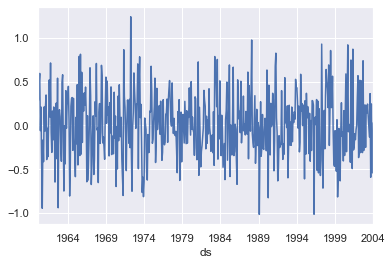

In [53]:
resid.plot()

<AxesSubplot:>

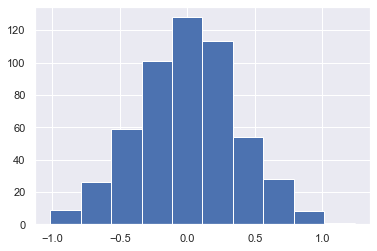

In [54]:
resid.hist()

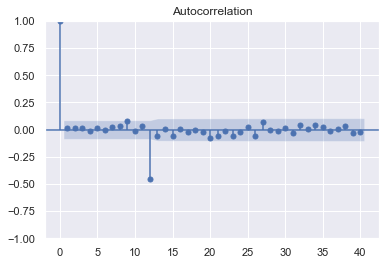

In [55]:
plot_acf(resid, lags = 40)
plt.show()

In [56]:
sm.stats.acorr_ljungbox(resid, lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,4.696915,0.910484,4.608454,0.915754


### 2.E - 6 pts 6 pts Predict the test set. Include the following: MAE, MSE, MAPE, sMAPE, MASE. Can use prebuilt functions or calculate by hand.

In [57]:
y_pred=sarima_fit.forecast(steps = len(y_test))

<AxesSubplot:xlabel='ds'>

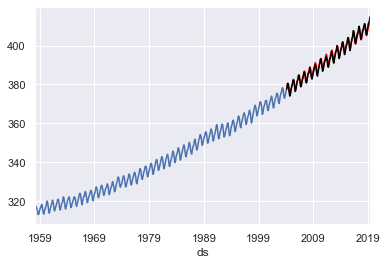

In [58]:
# plot
y_train.plot()
y_pred.plot(color='red')
y_test.plot(color = 'black')

In [59]:
def plot_results(y_train, y_test, y_pred):
    # plot the results
    y_train.plot()
    y_test.plot()

    y_pred.plot()

    plt.legend(['y_train','y_test','y_pred'])
    plt.show()

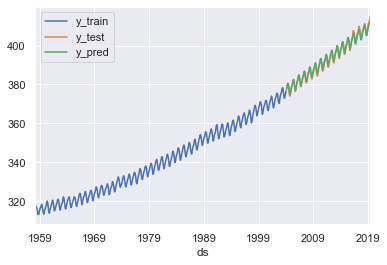

In [60]:
# model prediction
plot_results(y_train, y_test, y_pred)

In [61]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [62]:
#calculate SMAPE
smape(y_test, y_pred)

0.19813672253922326

In [63]:
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
mase = MeanAbsoluteScaledError()
mase(y_test, y_pred, y_train=y_train)

0.7256855376657716

In [64]:
from sktime.performance_metrics.forecasting import MeanAbsoluteError
mae = MeanAbsoluteError()
mae(y_test, y_pred)

0.7811147184609339

In [65]:
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError()
mse(y_test, y_pred)

0.818691887801157

In [66]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
mape = MeanAbsolutePercentageError(symmetric=False)
mape(y_test, y_pred)

0.0019824266843486943

In [67]:
sarima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                 co2   No. Observations:                  551
Model:             SARIMAX(3, 1, 1)x(0, 1, [], 12)   Log Likelihood                -241.462
Date:                             Sat, 30 Apr 2022   AIC                            492.924
Time:                                     02:05:05   BIC                            514.363
Sample:                                 03-31-1958   HQIC                           501.310
                                      - 01-31-2004                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0375      0.331      0.113      0.910      -0.611       0.686
ar.L2          0.0076      0.125      0.060      0.952      -0.238       0.253
ar.L3         -0.0674      0.065     -1.041      0.298      -0.194       0.059
ma.L1         -0.4052      0.330     -1.227      0.220      -1.053       0.242
sigma2         0.1436      0.009     16.155      0.000       0.126       0.161
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.67
Prob(Q):                              0.99   Prob(JB):                         0.71
Heteroskedasticity (H):               0.76   Skew:                             0.09
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 3. 30 pts – Auto ARIMA – need to use pmdarima in order to examine residuals
### 3.A - 6 pts Fit using auto_arima(), you may need to provide the differencing orders.

In [68]:
from sktime.forecasting.arima import AutoARIMA
from pmdarima.arima import auto_arima

In [69]:
y_train, y_test = temporal_train_test_split(ts)

In [70]:
y_train.index.min(), y_train.index.max()

(Period('1958-03', 'M'), Period('2004-01', 'M'))

In [71]:
y_test.index.min(), y_test.index.max()

(Period('2004-02', 'M'), Period('2019-05', 'M'))

## Model 1 (AutoARIMA)

In [72]:
#arima_model = AutoARIMA(D=1, sp=12, order=(3,1,0), seasonal_order=(0, 1, 0, 12))
arima_model = AutoARIMA(D=1, sp=12)
arima_model.fit(y_train)
fh = list(range(1, 1+len(y_test)))
y_pred = arima_model.predict(fh=fh )

## Model 2 (auto_arima)

In [73]:
stepwise_model = auto_arima(y_train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=234.554, Time=0.87 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=555.695, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=378.350, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=234.067, Time=0.57 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=489.714, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=235.773, Time=0.52 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=235.743, Time=2.14 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=368.160, Time=0.18 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=237.449, Time=2.52 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=234.986, Time=0.56 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=242.703, Time=0.43 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=235.889, Time=1.08 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=233.480, Time=0.81 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   

### 3.B - 6 pts Return the model summary

In [74]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  551
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -111.667
Date:                            Sat, 30 Apr 2022   AIC                            233.335
Time:                                    02:06:56   BIC                            254.774
Sample:                                         0   HQIC                           241.721
                                            - 551                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0017      0.001      1.784      0.074      -0.000       0.004
ar.L1          0.2042      0.111      1.845      0.065      -0.013       0.421
ma.L1         -0.5416      0.099     -5.476      0.000      -0.736      -0.348
ma.S.L12      -0.8647      0.025    -34.889      0.000      -0.913      -0.816
sigma2         0.0860      0.005     16.183      0.000       0.076       0.096
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.25
Prob(Q):                              0.84   Prob(JB):                         0.88
Heteroskedasticity (H):               0.83   Skew:                            -0.05
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [75]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  551
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -111.667
Date:                            Sat, 30 Apr 2022   AIC                            233.335
Time:                                    02:06:56   BIC                            254.774
Sample:                                         0   HQIC                           241.721
                                            - 551                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0017      0.001      1.784      0.074      -0.000       0.004
ar.L1          0.2042      0.111      1.845      0.065      -0.013       0.421
ma.L1         -0.5416      0.099     -5.476      0.000      -0.736      -0.348
ma.S.L12      -0.8647      0.025    -34.889      0.000      -0.913      -0.816
sigma2         0.0860      0.005     16.183      0.000       0.076       0.096
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.25
Prob(Q):                              0.84   Prob(JB):                         0.88
Heteroskedasticity (H):               0.83   Skew:                            -0.05
Prob(H) (two-sided):                  0.22   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3.C - 6 pts Examine the residuals. Include the following: plot, histogram, ACF, Ljung Box results

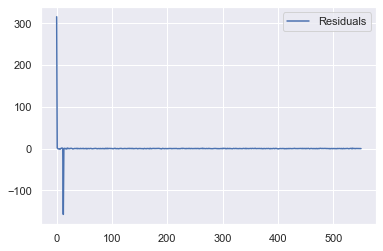

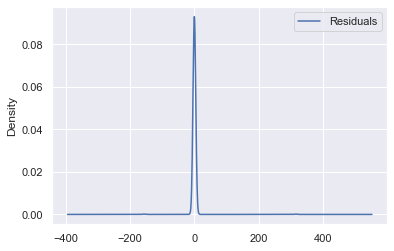

        Residuals
count  551.000000
mean     0.286846
std     15.048100
min   -157.683284
25%     -0.200561
50%      0.004809
75%      0.200398
max    315.697811


In [76]:
# residual checks
# line plot of residuals
res = stepwise_model.resid()
residuals = pd.DataFrame(res,columns=["Residuals"])
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [77]:
resid = residuals[24:]
resid

,Residuals
24,0.366861
25,0.118676
26,0.743492
27,0.284696
28,-0.043028
...,...
546,0.182961
547,-0.022264
548,-0.167600
549,-0.175216


<AxesSubplot:>

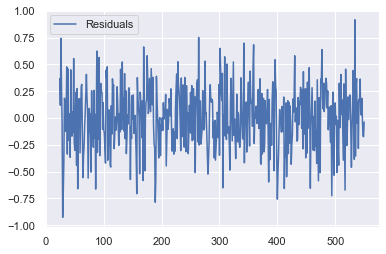

In [78]:
resid.plot()

array([[<AxesSubplot:title={'center':'Residuals'}>]], dtype=object)

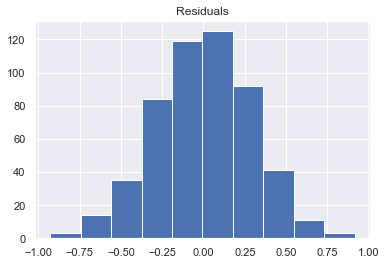

In [79]:
resid.hist()

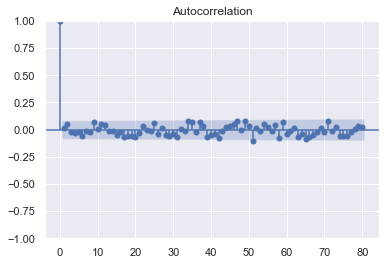

In [80]:
plot_acf(resid, lags = 80)
plt.show()

In [81]:
sm.stats.acorr_ljungbox(resid, lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,7.840433,0.64442,7.72041,0.656126


### 3.D - 6 pts Predict the test set. Include the following: MAE, MSE, MAPE, sMAPE, MASE. Can use prebuilt functions or calculate by hand.

## Model 1 (AutoARIMA)

<AxesSubplot:xlabel='ds'>

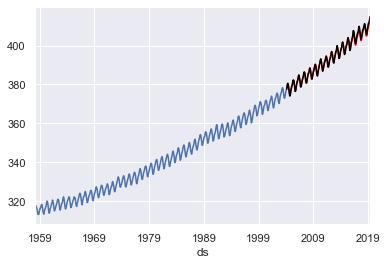

In [82]:
# plot
y_train.plot()
y_pred.plot(color='red')
y_test.plot(color = 'black')

## Model 2 (auto_arima)

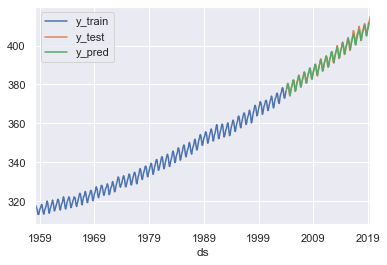

In [83]:
# model prediction
plot_results(y_train, y_test, y_pred)

In [84]:
#calculate SMAPE
smape(y_test, y_pred)

0.12339355862730896

In [85]:
mase(y_test, y_pred, y_train=y_train)

0.4563038898869482

In [86]:
mae(y_test, y_pred)

0.4911572106399497

In [87]:
mse(y_test, y_pred)

0.4377115922873344

In [88]:
mape(y_test, y_pred)

0.001233097629174211

### 3.E - 6 pts Summarize the difference between your SARIMA and the Auto Arima models. Compare order, performance on training data, performance on test data. Which model would you go forward with?
- For our SARIMA model, the order used was (3, 1, 1)(0, 1, 0, 12) while the AutoARIMA Best model was:  ARIMA(1,1,1)(0,1,1)[12]
- Comparison of various error measurements (e.g., MAE, MSE, MAPE, sMAPE, MASE) we can see very similar values, but if given the choice in a professional setting I would use AutoARIMA. The errors are listed below: 
- SARIMA:
    - sMAPE = 0.19813672253922326
    - MASE = 0.7256855376657716
    - MAE = 0.7811147184609339
    - MSE = 0.818691887801157
    - MAPE = 0.0019824266843486943
- AutoARIMA: 
    - sMAPE = 0.12339355862730896
    - MASE = 0.4563038898869482
    - MAE = 0.4911572106399497
    - MSE = 0.4377115922873344
    - MAPE = 0.001233097629174211
- The advantage of using Auto ARIMA over the SARIMA model is that after data preprocessing step we can skip the next steps & directly fit our model. In other words, we do not have to spend a lot of time determining a best estimate of seasonal and non-seasonal order. 
- Auto ARIMA uses the AIC (Akaike Information Criterion) & BIC(Bayesian Information Criterion) values generated by trying different combinations of p,q & d values to fit the model.

## 4. 30 pts plus 20 pts extra credit – Recursive method with best model
### 4.A - A. 10 pts Use/modify the rolling fit class to fit and predict with the best model from above. Adjust train size from the sample in RollingFit_for_Assignment4.ipynb. This probably works best w sktime implementation.

In [89]:
df = pd.read_csv('hw4_data.csv', index_col = 0)

In [90]:
df.index = pd.core.indexes.period.PeriodIndex(df.index, freq='m')

In [91]:
class RollingFit:
    def __init__(self, df, train_size=5, model=AutoARIMA() ):
        
        self.df = df
        self.model = model
        
        self.train_df, self.test_df = temporal_train_test_split(df, train_size=5)
        self._test_df = self.test_df
        self.dfpred_ = self.train_df
        self.fit()
        
    def fit(self):
        N = len( self.test_df )
        for i in range(0, N):
            
            self.fit_model()
            dfpred = self.predict_one()
            self.add_to_predictions( dfpred )
            self.move_one_test_to_train()
            self.drop_one_from_test()
    
    
    def fit_model(self):
        df = self.train_df
        self.model.fit( df )
        
    def predict_one(self):
        dfpred = self.model.predict(1)
        return dfpred
    
    def add_to_predictions(self, dfpred):
        self.dfpred_ = pd.concat([self.dfpred_, dfpred])
        
        
    def move_one_test_to_train(self):
        series_to_add = pd.Series( 
            self.test_df[0], 
            index = [ self.test_df.index[0] ] 
        )
        self.train_df = pd.concat( [self.train_df, series_to_add ])    
    
    def drop_one_from_test(self):
        self.test_df = self.test_df[1:]

In [92]:
rolling_fit_model = RollingFit(df['co2'], model=ARIMA((1,1,1), seasonal_order=(0,0,0,1) ))

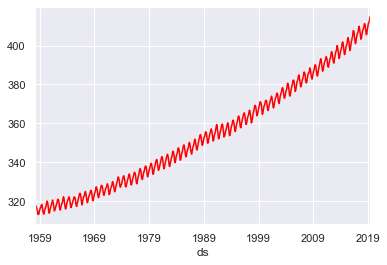

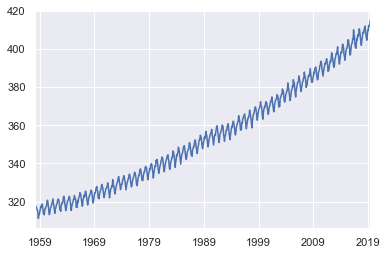

In [93]:
rolling_fit_model.df.plot(color='red')
plt.show()
rolling_fit_model.dfpred_.plot()
plt.show()

### 4.B - *20 pts extra credit* Create your own function or class to perform a different method of recursive forecasting. Can use any other recursive method, here is a paper for inspiration, not limitation: https://arxiv.org/pdf/1108.3259.pdf

In [94]:
df = pd.read_csv('hw4_data.csv', parse_dates = ['ds'])

In [95]:
#df.index = pd.core.indexes.period.PeriodIndex(df.index, freq='m')

In [96]:
# selecting variable of intest & build uniform univariate time series
#ts = df.groupby(pd.PeriodIndex(df['ds'], freq="M"))['co2'].mean()
#ts.plot()

<AxesSubplot:xlabel='ds'>

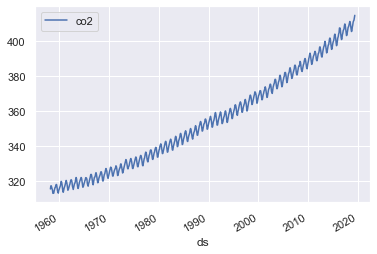

In [97]:
# set date as index
df.set_index('ds', inplace = True)
df.plot()

In [98]:
y_train, y_test = temporal_train_test_split(df)

In [99]:
print(f"Train dates : {y_train.index.min()} --- {y_train.index.max()}  (n={len(y_train)})")
print(f"Test dates  : {y_test.index.min()} --- {y_test.index.max()}  (n={len(y_test)})")

Train dates : 1958-03-15 00:00:00 --- 2004-01-15 00:00:00  (n=551)
Test dates  : 2004-02-15 00:00:00 --- 2019-05-15 00:00:00  (n=184)


In [100]:
y_train

,co2
ds,
1958-03-15,315.700
1958-04-15,317.450
1958-05-15,317.510
1958-06-15,316.685
1958-07-15,315.860
...,...
2003-09-15,372.980
2003-10-15,373.000
2003-11-15,374.350


In [101]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


In [102]:
# Function to calculate predictors from time series
# ==============================================================================
def custom_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    lags = y[-1:-11:-1]
    mean = np.mean(y[-20:])
    predictors = np.hstack([lags, mean])
    
    return predictors

In [103]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestRegressor(random_state=123),
                fun_predictors = custom_predictors,
                window_size    = 20
             )

forecaster.fit(y=y_train['co2'])
forecaster

ForecasterAutoregCustom 
Regressor: RandomForestRegressor(random_state=123) 
Predictors created with function: custom_predictors 
Window size: 20 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 550] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-04-30 02:07:36 
Last fit date: 2022-04-30 02:07:36 
Skforecast version: 0.4.3 

In [104]:
print(forecaster.source_code_create_predictors)

def custom_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    lags = y[-1:-11:-1]
    mean = np.mean(y[-20:])
    predictors = np.hstack([lags, mean])
    
    return predictors



In [105]:
X, y = forecaster.create_train_X_y(y=y_train['co2'])
y

20     314.81
21     315.58
22     316.43
23     316.98
24     317.58
        ...  
546    372.98
547    373.00
548    374.35
549    375.69
550    376.79
Name: y, Length: 531, dtype: float64

## Predictions

In [106]:
steps = 184
y_pred = forecaster.predict(steps=steps)
y_pred

551    376.8448
552    376.7629
553    376.6787
554    376.5962
555    376.2762
         ...   
730    376.6186
731    376.6186
732    376.6186
733    376.6186
734    376.6186
Name: pred, Length: 184, dtype: float64

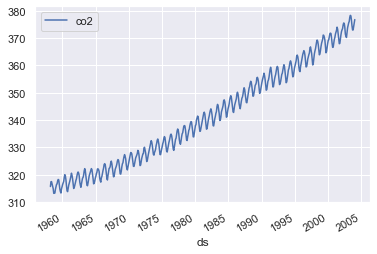

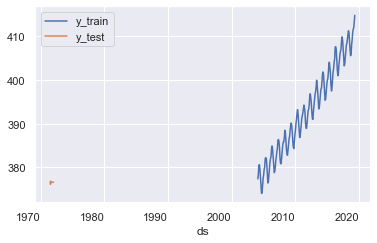

In [107]:
plot_results(y_train, y_test, y_pred)

## Plot

<AxesSubplot:xlabel='ds'>

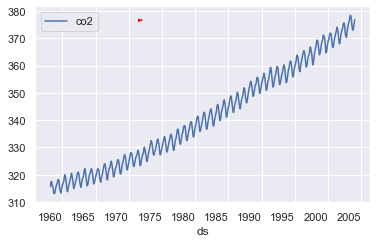

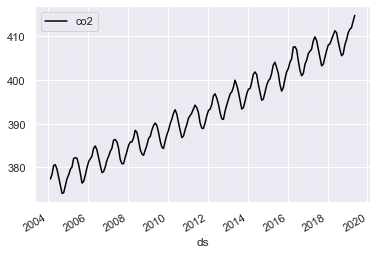

In [108]:
# plot
y_train.plot()
y_pred.plot(color='red')
y_test.plot(color = 'black')

In [109]:
# Hyperparameter Grid search
# ==============================================================================
steps = 184
forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestRegressor(random_state=123),
                fun_predictors = custom_predictors,
                window_size    = 20
             )

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = y_train['co2'],
                        param_grid  = param_grid,
                        steps       = steps,
                        refit       = True,
                        metric      = 'mean_absolute_percentage_error',
                        initial_train_size = int(len(y_train)*0.5),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False
               )

Number of models compared: 6


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:23<00:00, 23.04s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: custom predictors 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 0.02645234947196659



In [110]:
results_grid

,lags,params,metric,max_depth,n_estimators
4,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.026452,10,100
5,custom predictors,"{'max_depth': 10, 'n_estimators': 500}",0.026716,10,500
2,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.027252,5,100
3,custom predictors,"{'max_depth': 5, 'n_estimators': 500}",0.027378,5,500
1,custom predictors,"{'max_depth': 3, 'n_estimators': 500}",0.031566,3,500
0,custom predictors,"{'max_depth': 3, 'n_estimators': 100}",0.031677,3,100


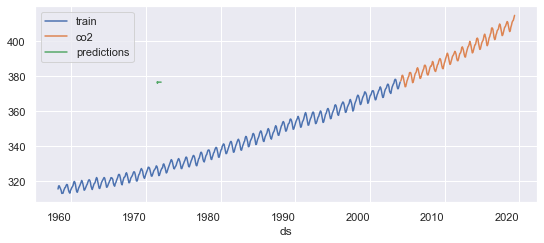

In [111]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
y_train['co2'].plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();


In [112]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(y_true = y_test, y_pred = predictions)
print(f"Test error (mse) {error_mse}")

Test error (mse) 370.6707730104536


### 4.C - 10 pts Include the following: MAE, MSE, MAPE, sMAPE, MASE. Can use prebuilt functions or calculate by hand.

In [113]:
#calculate SMAPE
smape(y_test, y_pred)

co2    0.0
551    0.0
552    0.0
553    0.0
554    0.0
      ... 
730    0.0
731    0.0
732    0.0
733    0.0
734    0.0
Length: 185, dtype: float64

In [114]:
mase(y_test, y_pred, y_train=y_train)

15.324587229724845

In [115]:
mae(y_test, y_pred)

16.49510706521711

In [116]:
mse(y_test, y_pred)

373.5904053754793

In [117]:
mape(y_test, y_pred)

0.041334409148387825

### 4.D - 10 pts Summarize the difference between your Recursive forecasts and your h-step ahead forecasts from SARIMA and Auto ARIMA. Explain the methodologies and the reason that you get different results. What are the advantages and disadvantages of the recursive method.
- Since the value 𝑡𝑛−1 is required to predict  𝑡𝑛, and  𝑡𝑛−1 is unknown, a recursive process is applied in which, each new prediction, is based on the previous one.
- With the ForecasterAutoreg class, a model is created and trained from a RandomForestRegressor regressor with a time window of 10 lags. This means that the model uses the previous 10 months as predictors.
- We observe the rolling approach makes use of fixed windows of data to re-estimate the parameters over the out-of-sample period, whereas the recursive approach makes use of an increasing window to re-estimate the models. 
- The advantage of this approach is that only one model is created and hence memory and computation requirements are relatively low. For the same reason, this approach is widely used for multi-step forecasting when the forecasting horizon is medium to long-term. 
- A disadvantage is as the forecasted values are used for the subsequent predictions, the model has a tendency to accumulate errors and therefore forecasting accuracy may drop significantly as forecasting horizon increases. Also, time taken for prediction is higher for the distant forecasts as it needs to wait for all prior forecasts to be generated.